# Model Training Script
This script extracts data from the snowflake table, transforms the features, and then traings the model on the engeneered features. Our training script leverages MLflow for model logging.

In [23]:
#!pip install snowflake-connector-python
#!pip install mlflow mlflow==1.22.0

In [24]:
import pandas as pd
import numpy as np
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
import argparse
import joblib
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Enable pandas to display up to 500 columns
pd.set_option('display.max_columns', 500)


#### 1.1 Load Snowflake credentials for temp user

In [25]:
# Load environment variables from a .env file
load_dotenv()

try:
    TEMP_USER = os.getenv('SNOWSQL_TEMP_USER')
    TEMP_USER_PASSWORD = os.getenv('SNOWSQL_TEMP_PWD')
    
    if not TEMP_USER:
        raise ValueError("Environment variable SNOWSQL_TEMP_USER must be set")
    if not TEMP_USER_PASSWORD:
        raise ValueError("Environment variable SNOWSQL_TEMP_PWD must be set")

except ValueError as ve:
    print(f"Error: {ve}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### 1.2 Connect to Snowflake

In [26]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account='ygeuort-alb19263',
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='ODS'
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-07-26 15:3830


In [27]:
def get_data(sql_query, date_columns=None):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.

    Args:
        sql_query (str): SQL query to execute.

    Returns:
        df_result: Resulting DataFrame from the SQL query.
    """
    try:
        cursor = conn.cursor()
        
        cursor.execute(sql_query)

        # load data into dataframe
        df_result = cursor.fetch_pandas_all()

        # Convert column names to lowercase
        df_result.columns = map(str.lower, df_result.columns)

        # Parse specified date columns
        if date_columns:
            for col in date_columns:
                df_result[col] = pd.to_datetime(df_result[col], errors='coerce')

    finally:
        if cursor is not None:
            cursor.close()

    return df_result

#### Extract data for all markets

In [28]:
sql_query = '''
select * from listings
 '''

df_raw = get_data(sql_query)
df_raw.shape

(111052, 68)

In [29]:
# Select features and target for the model
features = ['market', 'room_type', 'accommodates', 'bathrooms', 'beds', 'latitude', 'longitude']
categorical_features = ['market', 'room_type']  # Features with categorical data
numerical_features = ['accommodates', 'bathrooms', 'beds', 'latitude', 'longitude']  # Features with numerical data
# text_features = ['amenities']  # (Optional) Feature for text data like amenities
target = 'price'  # Target variable to predict

# Filter the dataframe to include only the selected features and target column
df = df_raw[features + [target]]

# Remove rows where the price exceeds $600 per night to avoid outliers
df = df[df[target] <= 600]

# Drop rows with missing values in the target column to ensure data integrity
df = df.dropna(subset=[target])

# Separate the features (X) and the target (y)
X = df.drop(columns=[target])
y = df[target]

# Split the data into training and test sets to evaluate model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cross-validation MAE scores: [47.96334117 46.84683432 46.87584983 47.81943364 46.68176909]
Average cross-validation MAE: 47.23744561174635
Test set MAE: 47.03104397033615


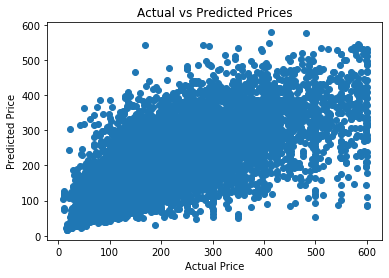

In [30]:
# Define the pipeline
def createPipeline(numerical_features, categorical_features):
    # Define the preprocessing for numerical features
    numericalTransformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Define the preprocessing for categorical features
    categoricalTransformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numericalTransformer, numerical_features),
            ('cat', categoricalTransformer, categorical_features)
        ])
    
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    return pipeline

# Function to log parameters, metrics, and features to a text file
def log_to_file(log_file, params, metrics):
    with open(log_file, 'w') as f:
        f.write("Parameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
        f.write("\nMetrics:\n")
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")

# Parameters and file paths
log_file = 'experiment_log.txt'
model_file = 'regression_pipeline.joblib'

# Create the pipeline
pipeline = createPipeline(numerical_features, categorical_features)

# Perform cross-validation with Mean Absolute Error (MAE)
maeScores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
maeScores = -maeScores  # Convert negative MAE to positive
print("Cross-validation MAE scores:", maeScores)
print("Average cross-validation MAE:", maeScores.mean())

# Parameters and metrics to log
params = {
    "model_type": "RandomForestRegressor",
    "n_estimators": 100,
    "numerical_features": numerical_features,
    "categorical_features": categorical_features
}
metrics = {
    "cv_mae_mean": maeScores.mean(),
    "cv_mae_std": maeScores.std()
}

# Log parameters and metrics to file
log_to_file(log_file, params, metrics)

# Train the model on the entire training set
pipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set using MAE
y_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print("Test set MAE:", mae_test)

# Log test MAE to file
with open(log_file, 'a') as f:
    f.write(f"\ntest_mae: {mae_test}\n")

# Save the model
joblib.dump(pipeline, model_file, compress=('gzip', 3))

# Plot the results
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()
